#### Welcome to the Parallel C OpenMP hand-on session. 

#### In this Jupyter Notebook, you are provided with four scientific programming tasks that can be accelerated by OpenMP multithreading. Each example highlights a distinct loop-parallelization theme and showcases different strategies.

In [1]:

import os
# the jupyter notebook is launched from your $HOME, change the working directory provided a username directory is created under /scratch/vp91
os.chdir(os.path.expandvars("/scratch/vp91/$USER/OpenMP-C"))



# Exercise 1. (Independent Loop Iterations) Monte-Carlo $\pi$

Consider the quarter of a unit circle inscribed in the unit square $[0,1]^2$. Draw $N$ points uniformly at random in the square, and let $h$ be the number that fall inside the quarter circle $(x^2+y^2\le 1)$. By the area ratio,
\begin{align*}
\hat{\pi} \approx \frac{4h}{N}.
\end{align*}

Increasing $N$ reduces the estimator’s variance (error estimate is $O(N^{-1/2})$). Because each sample is independent, this Monte Carlo approach is *embarrassingly parallel*, making it an ideal example for OpenMP Multithreading paralelisation.



Note that in the python-based Jupyter environment you are working on, we need to prepend lines of code with `!` to indicate we wish to execute a shell command.

In [2]:
# Compilee the serial code
!gcc -g -Wall -O3 -o monte-carlo-pi-serial monte-carlo-pi-serial.c -lm

In [3]:
%%time
#Execute the serial code
!./monte-carlo-pi-serial

MATH Pi 3.141592653589793
/////////////////////////////////////////////////////
Sampling points 10; Hit numbers 8; Approx Pi 3.200000
Sampling points 100; Hit numbers 81; Approx Pi 3.240000
Sampling points 1000; Hit numbers 770; Approx Pi 3.080000
Sampling points 10000; Hit numbers 7933; Approx Pi 3.173200
Sampling points 100000; Hit numbers 78637; Approx Pi 3.145480
Sampling points 1000000; Hit numbers 785130; Approx Pi 3.140520
Sampling points 10000000; Hit numbers 7852062; Approx Pi 3.140825
Sampling points 100000000; Hit numbers 78540785; Approx Pi 3.141631
Sampling points 1000000000; Hit numbers 785396116; Approx Pi 3.141584
CPU times: user 148 ms, sys: 25.5 ms, total: 174 ms
Wall time: 9.5 s


### Exercise 1.1: 
Add the worksharing-loop in monte-carlop-pi-openmp.c. 

In [29]:
# Compile the openmp code
!gcc -fopenmp -g -Wall -O3 -lm -o monte-carlo-pi-openmp monte-carlo-pi-openmp.c 

In [30]:
%%time

# Execute the openmp code, compare the time consumption with the serial version
!OMP_NUM_THREADS=4 ./monte-carlo-pi-openmp

MATH Pi 3.141592653589793
/////////////////////////////////////////////////////
Sampling points 10; Hit numbers 6; Approx Pi 2.400000 with error 0.741593 
OpenMP time: 0.000220 
Sampling points 100; Hit numbers 83; Approx Pi 3.320000 with error 0.178407 
OpenMP time: 0.000012 
Sampling points 1000; Hit numbers 770; Approx Pi 3.080000 with error 0.061593 
OpenMP time: 0.000072 
Sampling points 10000; Hit numbers 7878; Approx Pi 3.151200 with error 0.009607 
OpenMP time: 0.000705 
Sampling points 100000; Hit numbers 78536; Approx Pi 3.141440 with error 0.000153 
OpenMP time: 0.007091 
Sampling points 1000000; Hit numbers 785320; Approx Pi 3.141280 with error 0.000313 
OpenMP time: 0.043037 
Sampling points 10000000; Hit numbers 7855203; Approx Pi 3.142081 with error 0.000489 
OpenMP time: 0.366079 
Sampling points 100000000; Hit numbers 78537167; Approx Pi 3.141487 with error 0.000106 
OpenMP time: 3.666614 
Sampling points 1000000000; Hit numbers 785392734; Approx Pi 3.141571 with error

# Exercise #2 (Dynamic Loop Iterations) Mandelbrot Set
## Mandelbrot Set

The **Mandelbrot set** is the set of complex numbers $c \in \mathbb{C}$ for which the sequence

$$z_{n+1} = z_n^2 + c,\qquad z_0 = 0$$
remains **bounded** (does not diverge to infinity).

We write
$$
M \;=\; \Big\{\, c \in \mathbb{C} \;\big|\; \{z_n\}_{n\ge 0}\ \text{is bounded for } z_{n+1}=z_n^2+c,\ z_0=0 \,\Big\}.
$$

### Convergence (Escape) Test
For visualization, we sample $c$ on a uniform grid over the rectangle
$$
[-2.0,\ 0.47] \times [-1.12,\ 1.12]\,i,
$$
which covers the most visually interesting portion of $M$.

For each grid point $c$, iterate the map up to $N_{\max}=100$ steps:
$$
z_{n+1} = z_n^2 + c,\quad n=0,\dots, N_{\max}-1.
$$
If at any step $|z_n| > 2$ (equivalently $|z_n|^2 > 4$), the orbit is guaranteed to diverge and $c \notin M$. If $|z_n|$ never exceeds $2$ within $N_{\max}$ steps, we treat $c$ as (numerically) belonging to $M$.

### Dynamic Workload
Different points require different numbers of iterations before diverging (some escape in a few steps, others never escape within \(N_{\max}\)). This **variable iteration count** creates load imbalance in parallel implementations. To mitigate this with OpenMP, use **dynamic scheduling** (e.g., `schedule(dynamic, chunk)`) so threads pick up new points as they finish, improving overall utilization.

 

Part 1. Compile and run the serial version of mandelbrot set generator.

In [3]:
# Compile the serial code

!gcc -Wall -O3 mandelbrot-serial.c -o mandelbrot-serial

In [4]:
# Execute the serial program 
!./mandelbrot-serial

Resolution #0: 100 x 100
Resolution #1: 1000 x 1000
Resolution #2: 10000 x 10000


Matplotlib is building the font cache; this may take a moment.


time in loading  0.07221007347106934
time in plotting  0.198411226272583


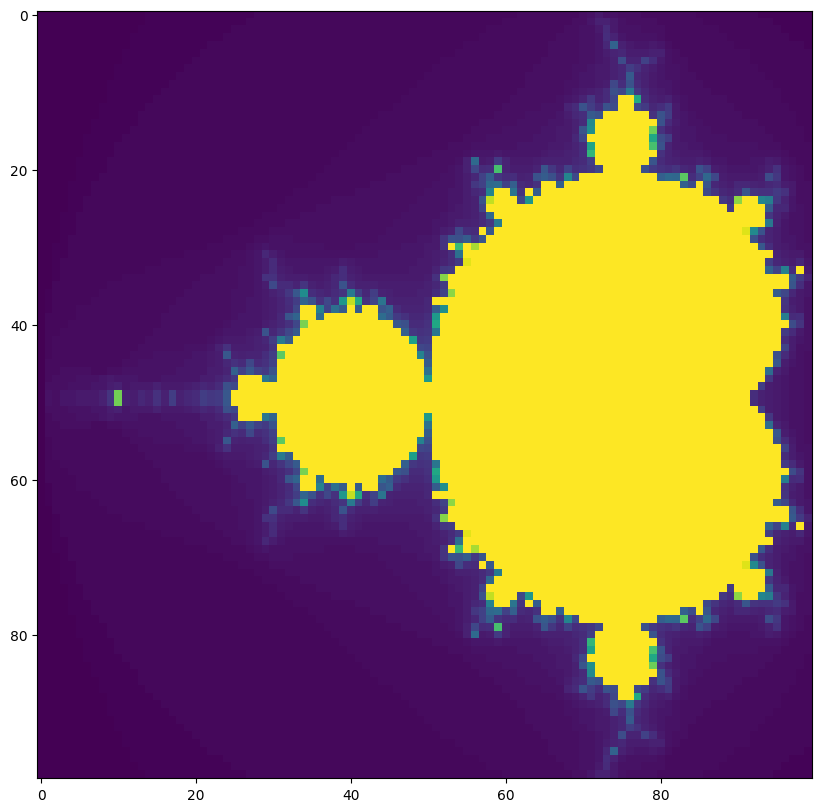

time in loading  0.24771785736083984
time in plotting  0.011650800704956055


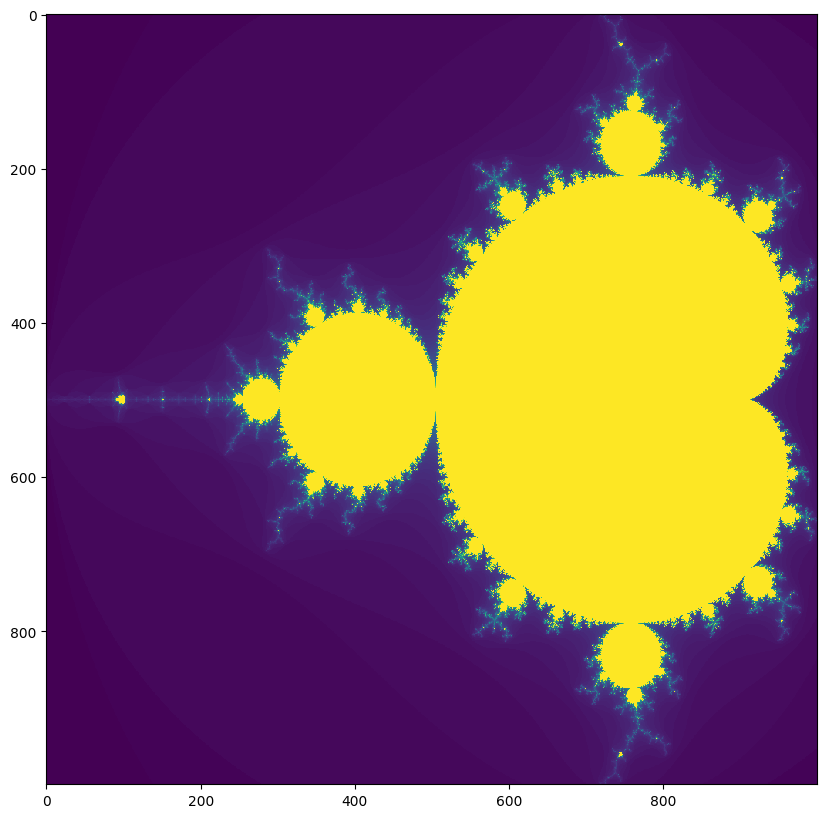

In [7]:
# Plot mandelbrot set to verify outputs
%run  'Mandelbrot-plot.py'

### Exercise 2.1
Add work-sharing loop constract and appropriate clauses in mandelbrot-omp.c. Make sure that writing in the output file is ordered. 

In [21]:
# Compile the openmp code
!gcc -fopenmp -g -Wall -O3 -o mandelbrot-omp mandelbrot-omp.c 

In [22]:
%%time
# Execute the openmp code

!OMP_NUM_THREADS=4  ./mandelbrot-omp

Resolution #0, Points 100 by 100 
Resolution #1, Points 1000 by 1000 
Resolution #2, Points 10000 by 10000 
CPU times: user 577 ms, sys: 106 ms, total: 682 ms
Wall time: 36.9 s


time in loading  0.04834771156311035
time in plotting  0.20439958572387695


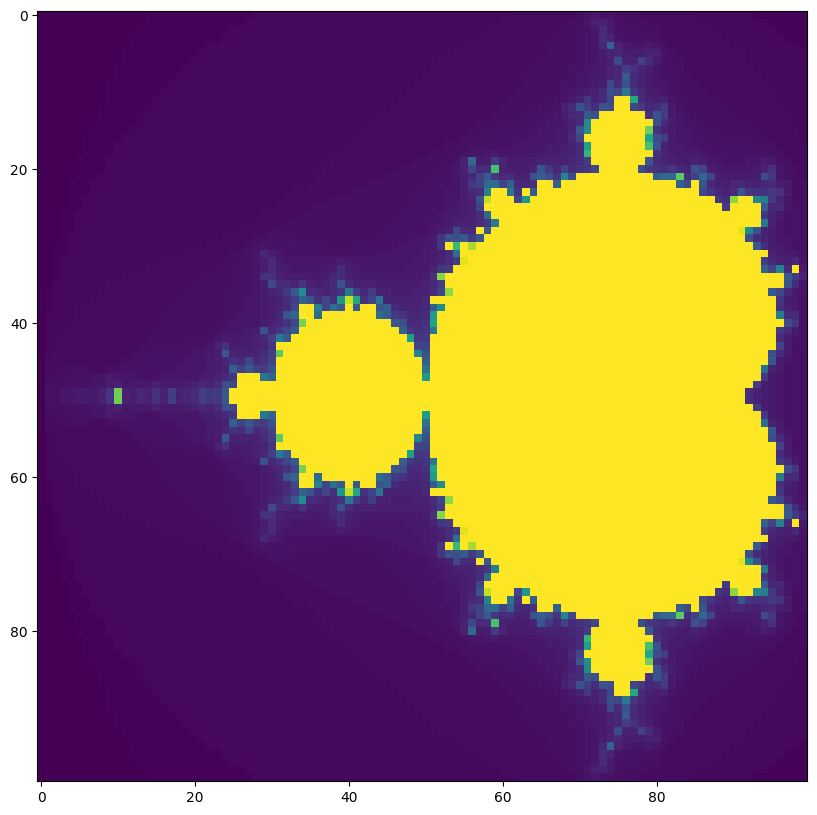

time in loading  0.07131028175354004
time in plotting  0.00977468490600586


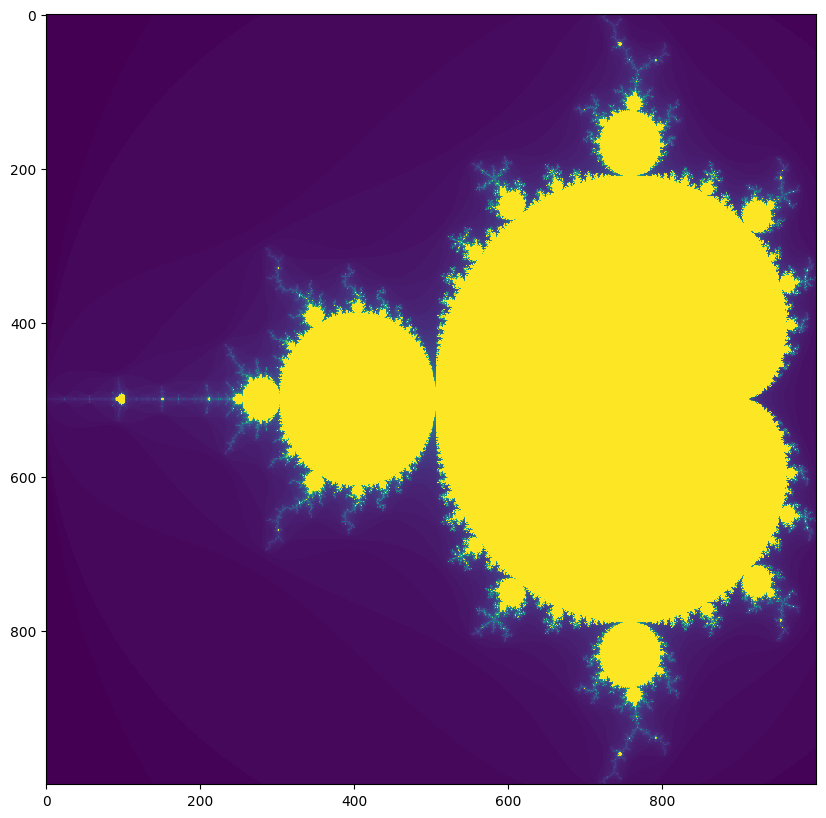

In [18]:
#  Verify the results by plot
%run  'Mandelbrot-plot.py'

You’ve probably noticed the OpenMP version doesn’t run faster. The culprit is the use of `ordered` around your output.

**What `ordered` does:**  
`ordered` enforces that a specific block inside a `parallel for` executes **in the original loop order**. Only one iteration at a time may enter that block. In other words, it **serializes** the part it wraps.

**What to do instead (best practice)**
- **Keep compute parallel, do I/O serially.**  
  Compute the iteration counts into a preallocated buffer in the `parallel for` and write the CSV **after** the parallel region.


### Exercise 2.2 
Modify mandelbrot-split.c to separate the I/O from the calculation routine. 

In [23]:
# compile the openmp code after IO separation
!gcc -fopenmp -g -Wall -O3 -o mandelbrot-split mandelbrot-split.c 


In [24]:
%%time
 
!OMP_NUM_THREADS=4  ./mandelbrot-split

Resolution #0, Points 100 by 100 
Resolution #1, Points 1000 by 1000 
Resolution #2, Points 10000 by 10000 
CPU times: user 159 ms, sys: 38 ms, total: 197 ms
Wall time: 10 s


time in loading  0.019127368927001953
time in plotting  0.018561840057373047


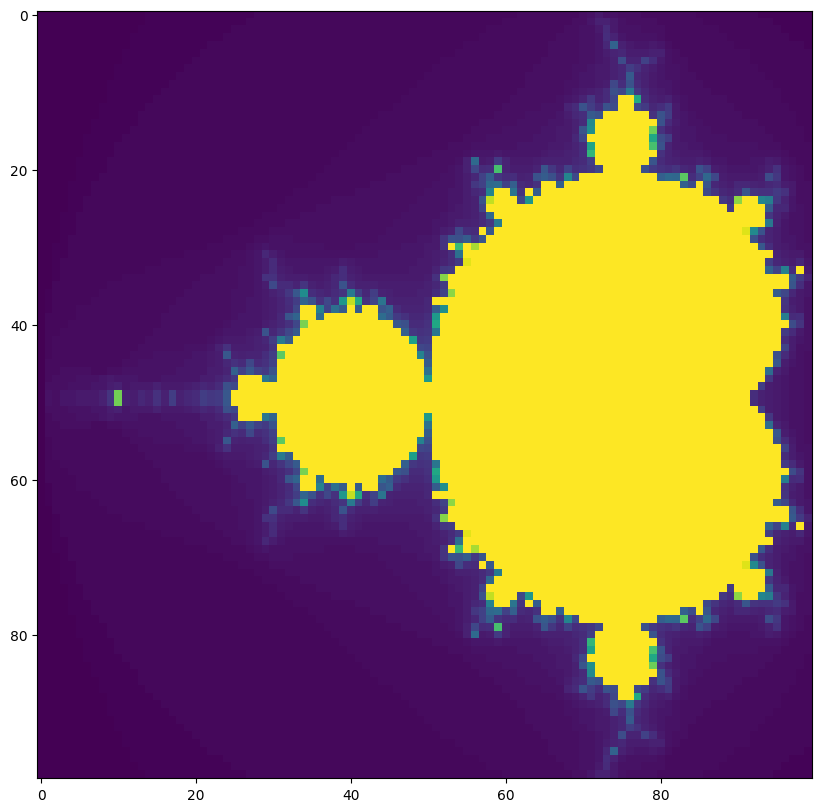

time in loading  0.07136774063110352
time in plotting  0.009120464324951172


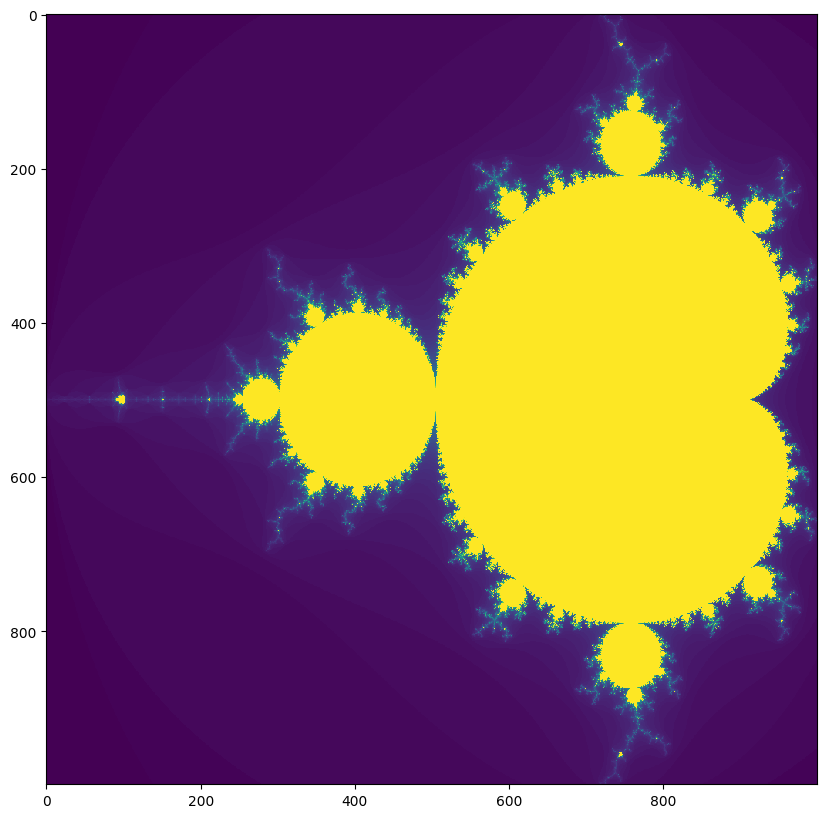

In [25]:
# Verify the output again by plot
%run  'Mandelbrot-plot.py'

# Exercise #3 (Loop Dependence). Solve Linear Equation by Conjugate Gradient Method 

The Conjugate Gradient method is a numerical method that is wildely used in solving certain type of matrix problems. It is also the base ingredient of [HPCG Benchmark](https://www.hpcg-benchmark.org/) for ranking HPC systems.


Consider solving a linear equation
\begin{align*}
Ax = b
\end{align*}
where matrix $A \in \mathbf{R}^{n\times n}$ is symmetric positive definite. 

The initial guess $x_0$ can be any approximation, we choose $0$. The baseline algorithm is statedd as following:

Compute $r_0 = b - Ax_0$

For $i= 0, \cdots, n$ Do 

 $\alpha_i := (r_i, r_i)/(Ap_i, p_i)$\;
 
 $x_{i+1}:=x_i+\alpha_i p_i$\;

 $r_{i+1}:=r_i -\alpha_i Ap_i$\;
 
 If $r_{i+1} <\text{tolerance}$ Then Break
 
 $\beta_i:= (r_{i+1}, r_{i+1}) / (r_i, r_i)$\;
 
 $p_{i+1}:= r_{i+1} +\beta_i p_i$

Conjugate Gradient method is a direct method that produces the exact solution at most $n$ steps, however, in practice a tolerance is usually set to terminate iterations.

CG method guarantees convergence for symmetric positive definite matrices in theory.



### Parallelisation in CG method
Note that the for-loop in CG method possesses the dependence between iterations. With multiple threads, each iteration can only be execute only after the dependence is met leading to a non-parallelizable loop. 

That being said, we can still use OpenMP to parallelise part of the code after analysing the bottleneck of its performance!

### Test Matrices
For numerical experiments, we will test two matrices [Trefethen_20](https://www.cise.ufl.edu/research/sparse/matrices/JGD_Trefethen/Trefethen_20.html) and [Msc04515](https://www.cise.ufl.edu/research/sparse/matrices/Boeing/msc04515.html).

Trefethen_20 is a small-sized problem in which you should see a fast convergence.

Msc04515 is a real-life problem arising from a structural engineering. It is an ill-conditioned matrix, which essentially means hard to solve and requires a lot more iterations for CG method if it converges at all.

In [2]:
# Compile the serial code

!gcc -g -Wall -O3 -lm -o cg-std cg-std.c 

In [3]:
# Execute the serial program to solve Trefethen_20 problem
!./cg-std 1e-5 < Trefethen_20.dat

iter    1  |r| = 2.514176e+00
iter    2  |r| = 1.700543e+00
iter    3  |r| = 1.203484e+00
iter    4  |r| = 9.354704e-01
iter    5  |r| = 6.801852e-01
iter    6  |r| = 5.439985e-01
iter    7  |r| = 4.789872e-01
iter    8  |r| = 3.803587e-01
iter    9  |r| = 3.185791e-01
iter   10  |r| = 2.151399e-01
iter   11  |r| = 1.867304e-01
iter   12  |r| = 1.698870e-01
iter   13  |r| = 1.414190e-01
iter   14  |r| = 9.204429e-02
iter   15  |r| = 7.366279e-02
iter   16  |r| = 4.264051e-02
iter   17  |r| = 2.583689e-02
iter   18  |r| = 1.106633e-02
iter   19  |r| = 3.311910e-03
iter   20  |r| = 1.737597e-12
CG finished in 19 iterations, time = 0.000163 s


### TODO
Add appropriate work-sharing loop construct and clauses in cg-std-omp.c

In [4]:
# Compile the openmp code
!gcc -fopenmp -g -Wall -O3 -lm -o cg-std-omp cg-std-omp.c 

In [5]:
%%time
# Verify the numerical result with the serial version
!OMP_NUM_THREADS=4  ./cg-std-omp 1e-5 < Trefethen_20.dat

iter    1  |r| = 2.514176e+00
iter    2  |r| = 1.700543e+00
iter    3  |r| = 1.203484e+00
iter    4  |r| = 9.354704e-01
iter    5  |r| = 6.801852e-01
iter    6  |r| = 5.439985e-01
iter    7  |r| = 4.789872e-01
iter    8  |r| = 3.803587e-01
iter    9  |r| = 3.185791e-01
iter   10  |r| = 2.151399e-01
iter   11  |r| = 1.867304e-01
iter   12  |r| = 1.698870e-01
iter   13  |r| = 1.414190e-01
iter   14  |r| = 9.204429e-02
iter   15  |r| = 7.366279e-02
iter   16  |r| = 4.264051e-02
iter   17  |r| = 2.583689e-02
iter   18  |r| = 1.106633e-02
iter   19  |r| = 3.311910e-03
iter   20  |r| = 1.737597e-12
CG finished in 19 iterations, time = 0.000535 s
CPU times: user 7.59 ms, sys: 3.7 ms, total: 11.3 ms
Wall time: 237 ms


In [6]:
%%time
# Excute the parallel code to solve Boeing msc04515 problem. You may also want to attempt this problem with the serial code

!OMP_NUM_THREADS=4 ./cg-std-omp 1e-5 < msc04515.dat

iter    1  |r| = 1.481366e+02
iter    2  |r| = 1.690940e+02
iter    3  |r| = 2.216508e+02
iter    4  |r| = 2.739382e+02
iter    5  |r| = 3.050054e+02
iter    6  |r| = 3.253083e+02
iter    7  |r| = 3.565421e+02
iter    8  |r| = 4.093285e+02
iter    9  |r| = 4.788408e+02
iter   10  |r| = 5.497009e+02
iter   11  |r| = 6.089089e+02
iter   12  |r| = 6.572429e+02
iter   13  |r| = 7.051263e+02
iter   14  |r| = 7.590662e+02
iter   15  |r| = 8.161639e+02
iter   16  |r| = 8.644275e+02
iter   17  |r| = 8.747067e+02
iter   18  |r| = 8.751981e+02
iter   19  |r| = 8.761456e+02
iter   20  |r| = 8.717281e+02
iter   21  |r| = 8.679077e+02
iter   22  |r| = 8.644748e+02
iter   23  |r| = 7.941729e+02
iter   24  |r| = 7.542271e+02
iter   25  |r| = 7.444906e+02
iter   26  |r| = 6.892509e+02
iter   27  |r| = 6.592922e+02
iter   28  |r| = 6.781115e+02
iter   29  |r| = 6.186262e+02
iter   30  |r| = 5.992710e+02
iter   31  |r| = 6.054500e+02
iter   32  |r| = 5.746722e+02
iter   33  |r| = 5.457865e+02
iter   34 

In [7]:
%%time
# Excute the parallel code to solve Boeing msc04515 problem. You may also want to attempt this problem with the serial code

!OMP_NUM_THREADS=4 ./cg-std 1e-5 < msc04515.dat

iter    1  |r| = 1.481366e+02
iter    2  |r| = 1.690940e+02
iter    3  |r| = 2.216508e+02
iter    4  |r| = 2.739382e+02
iter    5  |r| = 3.050054e+02
iter    6  |r| = 3.253083e+02
iter    7  |r| = 3.565421e+02
iter    8  |r| = 4.093285e+02
iter    9  |r| = 4.788408e+02
iter   10  |r| = 5.497009e+02
iter   11  |r| = 6.089089e+02
iter   12  |r| = 6.572429e+02
iter   13  |r| = 7.051263e+02
iter   14  |r| = 7.590662e+02
iter   15  |r| = 8.161639e+02
iter   16  |r| = 8.644275e+02
iter   17  |r| = 8.747067e+02
iter   18  |r| = 8.751981e+02
iter   19  |r| = 8.761456e+02
iter   20  |r| = 8.717281e+02
iter   21  |r| = 8.679077e+02
iter   22  |r| = 8.644748e+02
iter   23  |r| = 7.941729e+02
iter   24  |r| = 7.542271e+02
iter   25  |r| = 7.444906e+02
iter   26  |r| = 6.892509e+02
iter   27  |r| = 6.592922e+02
iter   28  |r| = 6.781115e+02
iter   29  |r| = 6.186262e+02
iter   30  |r| = 5.992710e+02
iter   31  |r| = 6.054500e+02
iter   32  |r| = 5.746722e+02
iter   33  |r| = 5.457865e+02
iter   34 

# Exercise #4 (Parallelisaton vs. Convergence Rate): Solve Finite Difference Discretised Poisson Equation by Jacobi and Gauss-Seidel Methods


### Model Problem
Consider a 2D Poisson equation with Dirichlet boundary condition over a unit square domain $\Omega = [0,1] \times [0,1]$

\begin{align*}
-\Delta u &= f \; \text{in} \; \Omega \\
 u &= g \; \text{on} \; \partial \Omega
\end{align*}

Define a uniform partition of the domain $\Omega$ with nodal points at which the solution of the Poisson equation is sampled. Let $h$ be the uniform distance between two nodal points then the nodal points that lie on the mesh are defined by

\begin{align*}
x_i = i h, \; y_j = j h\qquad i,j = 0,\cdots, N
\end{align*}
where $N$ is a given mesh size and $i, j$ are integers along $x, y$-axis telling the location of each nodal point.  


### Discretisation
We use the second-order central finite difference method to discretise the Laplace operator
\begin{align*}
(\Delta u)_{i,j}
  &= \bigl(D_{xx}^2 u\bigr)_{i,j} + \bigl(D_{yy}^2 u\bigr)_{i,j} \\[2ex]
  &\approx \frac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{h^2}
          + \frac{u_{i,j+1}-2u_{i,j}+u_{i,j-1}}{h^2}.
\end{align*}
leading to
\begin{align}
    -(\Delta u)_{i,j} = \frac{4u_{i,j}-u_{i+1,j}-u_{i-1,j}-u_{i,j+1}-u_{i,j-1}}{h^2}=f(u_{i,j}).
\end{align}

The above finite-difference formula can further be represented by a five-point stencil matrix built in the mesh
\begin{align*}S = 
    \begin{pmatrix}
    & -1 & \\
    -1 & 4 &-1\\
    & -1 &
    \end{pmatrix}.
\end{align*}

Impose the Dirichlet boundary condition, on the interior nodal points the discretisation can be written as a linear equation

\begin{align*}
A u = f, \qquad A=\frac{1}{h^2}
    \begin{pmatrix}
S & I \\
I & S & I \\
& I & \ddots & \ddots \\
& & \ddots & \ddots & I \\
& & & I & S
\end{pmatrix}
\end{align*}
where $A \in \mathbb{R}^{(N-2)^2 \times (N-2)^2}$, $u \in \mathbb{R}^{(N-2)^2}$ and $f \in \mathbb{R}^{(N-2)^2}$.

Note that with the five-point stencil, the matrix $A$ was never assembled and is nowhere in sight! 


### Numerical Solvers

To solve the linear system, two iterative methods are used and compared. 

$\textbf{Jacobi method}$

\begin{align*}
u^{(k+1)} = D^{-1}( f - Lu_{k} -Uu_k),
\end{align*}
where $D, L, U$ are the diagonal matrix, lower triangular matrix and upper triangular matrix of $A$, respectively.
Write into stecil,
\begin{align*}
u^{(k+1)}_{ij} = (h^2 f_{ij} + u^{(k)}_{i-1,j} +u^{(k)}_{i+1,j} + u^{(k)}_{i, j-1}+u^{(k)}_{i,j+1})/4 \qquad i,j = 1,\cdots, N-1 
\end{align*} 



$\textbf{Gauss-Seidel method}$ follows a similar scheme:

\begin{align*}
u^{(k+1)} = D^{-1} (f - L u_{k+1}- U u_k),
\end{align*}

Note that Gauss-Seidel method uses the most recent estimate to update.
 
Likewise, applying the Gauss-Seidel method doesn't require assembling $D, L, U$ matrices for finite-difference discretised Laplacian. 
Elementwise, we have 
\begin{align*}
u^{(k+1)}_{ij} = (h^2 f_{ij} + u^{(k)}_{i-1,j} +u^{(k+1)}_{i+1,j} + u^{(k+1)}_{i, j-1}+u^{(k)}_{i,j+1})/4 \qquad i,j = 1,\cdots, N-1 
\end{align*}

### Convergence Rate

Gauss Seidel method is known to be faster than Jacobi method (twice faster as stated in some textbooks), both of their convergence rate for our application is governed by the following theorem.

$\textbf{Theorem}\;$
The convergence rate of Jacobi and Gauss-Seidel method for the 5-point stencil finite difference method of the Poisson equation on a uniform mesh with size $h$ is
\begin{align*}
1- \mathcal{O}(h^2)
\end{align*}

As such, the convergence rate stalls as the mesh gets finer. To alleviate the shortcoming of the numerical method, let's try improving the perforance by OpenMP! 

In [14]:
# Compile the serial code
!gcc -g -Wall -O3 -lm -o fd_laplace-serial fd_laplace-serial.c 

In [15]:
# Execute the serial code with Jacobi method to solve on a grid of 300 x 300 meshes i.e. matrix size 90000 x 90000 at stopping criterion 1e-5.
!./fd_laplace-serial 300 1e-5 Jacobi

Jacobi METHOD IS IN USE
Residual after 1000 iteration: 2792.5315167908
Residual after 2000 iteration: 2642.5622881079
Residual after 3000 iteration: 2500.6469594138
Residual after 4000 iteration: 2366.3530066127
Residual after 5000 iteration: 2239.2711337460
Residual after 6000 iteration: 2119.0140255557
Residual after 7000 iteration: 2005.2151670396
Residual after 8000 iteration: 1897.5277264016
Residual after 9000 iteration: 1795.6234979903
Residual after 10000 iteration: 1699.1919020067
Residual after 11000 iteration: 1607.9390379313
Residual after 12000 iteration: 1521.5867887847
Residual after 13000 iteration: 1439.8719734940
Residual after 14000 iteration: 1362.5455447792
Residual after 15000 iteration: 1289.3718301166
Residual after 16000 iteration: 1220.1278134653
Residual after 17000 iteration: 1154.6024555670
Residual after 18000 iteration: 1092.5960507491
Residual after 19000 iteration: 1033.9196182693
Residual after 20000 iteration: 978.3943263470
Residual after 21000 itera

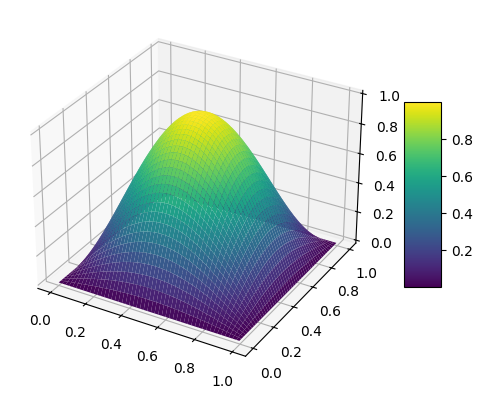

In [12]:
#  Verify the results by plot
%run  'Laplace-plot.py'

In [21]:
# Compile the parallel code

!gcc -fopenmp -g -Wall -O3 -lm -o fd_laplace-omp fd_laplace-omp.c 

In [19]:
# Execute the parallel code with Jacobi method to solve on a grid of 300 x 300 meshes i.e. matrix size 90000 x 90000 at stopping criterion 1e-5.

!OMP_NUM_THREADS=4 ./fd_laplace-omp 300 1e-5 Jacobi

Jacobi METHOD IS IN USE
Residual after 1000 iteration: 2792.5315167908
Residual after 2000 iteration: 2642.5622881079
Residual after 3000 iteration: 2500.6469594138
Residual after 4000 iteration: 2366.3530066127
Residual after 5000 iteration: 2239.2711337460
Residual after 6000 iteration: 2119.0140255556
Residual after 7000 iteration: 2005.2151670396
Residual after 8000 iteration: 1897.5277264016
Residual after 9000 iteration: 1795.6234979903
Residual after 10000 iteration: 1699.1919020067
Residual after 11000 iteration: 1607.9390379313
Residual after 12000 iteration: 1521.5867887847
Residual after 13000 iteration: 1439.8719734940
Residual after 14000 iteration: 1362.5455447791
Residual after 15000 iteration: 1289.3718301166
Residual after 16000 iteration: 1220.1278134653
Residual after 17000 iteration: 1154.6024555670
Residual after 18000 iteration: 1092.5960507491
Residual after 19000 iteration: 1033.9196182693
Residual after 20000 iteration: 978.3943263470
Residual after 21000 itera

In [ ]:
#  Verify the results by plotting
%run  'Laplace-plot.py'

In [24]:
# Recompile the parallel code again if you changed the Gauss-Seidel method

!gcc -fopenmp -g -Wall -O3 -lm -o fd_laplace-omp fd_laplace-omp.c 

In [ ]:
# Execute the parallel code with Gauss-Seidel method to solve on a grid of 300 x 300 meshes i.e. matrix size 90000 x 90000 at stopping criterion 1e-5.

!OMP_NUM_THREADS=4 ./fd_laplace-omp 300 1e-5 Gauss-Seidel 

Gauss-Seidel METHOD IS IN USE
Residual after 1000 iteration: 3737.2505744917
Residual after 2000 iteration: 3346.6208812605
Residual after 3000 iteration: 2996.8210853542
Residual after 4000 iteration: 2683.5835119277
Residual after 5000 iteration: 2403.0865575143
Residual after 6000 iteration: 2151.9080651817
Residual after 7000 iteration: 1926.9835730695
Residual after 8000 iteration: 1725.5689269263
Residual after 9000 iteration: 1545.2068005077
Residual after 10000 iteration: 1383.6967153716
Residual after 11000 iteration: 1239.0681943032
Residual after 12000 iteration: 1109.5567208321
Residual after 13000 iteration: 993.5822115392
Residual after 14000 iteration: 889.7297385093
Residual after 15000 iteration: 796.7322667356
Residual after 16000 iteration: 713.4551958679
Residual after 17000 iteration: 638.8825177075
Residual after 18000 iteration: 572.1044205667
Residual after 19000 iteration: 512.3061892607
Residual after 20000 iteration: 458.7582653090
Residual after 21000 iterat

In [ ]:
#  Verify the results by plot
%run  'Laplace-plot.py'